# Multilabel document classification of NOS articles

**Aim**: The aim of this project is to build a corpus from articles published to the Dutch NOS news website and to classify these in a multilabel classification fashion. <br>

Step 1: Corpus Extraction<br>
Step 2: Processing<br>
Step 3: Data modelling (model tuning)<br>
Step 4: Analaysis

In [1]:
from os import listdir
import numpy as np
import matplotlib.pyplot as plt

import urllib3
from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from scipy.stats import pearsonr

from datetime import datetime
from itertools import product, combinations_with_replacement, permutations, combinations

import warnings
warnings.filterwarnings('ignore')

import extractor # Custom functions

To extract the text from the NOS website I use `urlib3` to request the html document and `bs4` to parse the file. The custom functions in the `extractor.py` file extract the titel, date, cateogries, and text. The text and categories are saved in an array as `.npy` files with the date and title as the file name.

In [2]:
link_categories = ["binnenland","buitenland","regio","politiek","economie","koningshuis",
                   "tech","cultuur-en-media","opmerkelijk"]

extractor.scrape(link_categories)

path = ".\\articles"
articles = listdir(path)
articles.remove(".ipynb_checkpoints")

print(f"Total articles: {len(articles)}")

      binnenland |========================|
      buitenland |========================|
           regio |=========================|
        politiek |=========================|
        economie |=========================|
     koningshuis |===========|
            tech |=========================|
cultuur-en-media |=========================|
     opmerkelijk |===========|

Total articles: 1244


Now that the corpus has been created, the dictionaries and labels of each article are made. Also some statistics can be extracted.

In [9]:
article_stats = []
dictionaries = []
raw_labels = []

for article in articles:
    contents = np.load(f"{path}\\{article}", allow_pickle=True)
    text = contents[0]
    categories = contents[1]
    raw_labels.append(contents[1])
    dictionaries.append(contents[2])
    article_stats.append(contents[3:]) 

article_stats = np.asarray(article_stats).astype(float)
mean_stats = np.mean(article_stats, axis=0)
std_stats = np.std(article_stats, axis=0)

print(" "*28+"Avg (StDev)")
print(f"Words per article:        {mean_stats[0]:>5.1f} ({std_stats[0]:>5.1f})")
print(f"Unique words per article: {mean_stats[1]:>5.1f} ({std_stats[1]:>5.1f})")
print(f"Sentences per article:    {mean_stats[2]:>5.1f} ({std_stats[2]:>5.1f})")

                            Avg (StDev)
Words per article:        362.9 (211.1)
Unique words per article: 190.2 ( 84.2)
Sentences per article:     22.9 ( 13.2)


The statistics can also be visualized. Below, the relationship between the total number of words to the ratio of unique words to total number of words is shown. As the articles become longer more words are repeated and the ratio of unique words to total words drops.<br>
<br>
News articles have an incentive to remain short. Any additional length needs to be justified with more in depth content. This results in more unique words being introduced and the aformentioned ratio levels off as the articles become longer.<br>
<br>
A crude approximation of the trend is overlaid in a dashed black line.

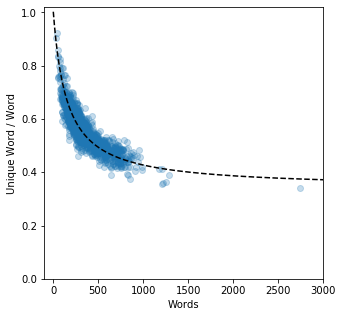

In [13]:
plt.figure(figsize=(5,5))
plt.scatter(article_stats[:,0],
            article_stats[:,1]/article_stats[:,0],
            alpha=0.25)
x = np.arange(1,3000)
plt.plot(x, 100/(x+150)+0.34, color="black",linestyle="dashed")
plt.xlabel("Words")
plt.ylabel("Unique Word / Word")
plt.xlim(-100,3000)
plt.ylim(0,1.02)

plt.savefig("images/unique_words_ratio_to_words.png",bbox_inches="tight")
plt.show()

## TF-IDF

In order to classify the documents, the *term frquency - inverse document frequency* scores are calculated. The inverse document frequency is adapted to be smoothed.<br>
<br>
**Train-Test Split**<br>
The data set must be divided prior to the creation of the TF-IDF matrix as the inverse document frequency can encode information from the test set into the training set. The data is split into train (4/5) and test sets (1/5).<br>

In [9]:
test_idx = round(len(dictionaries)*4/5)

train_dictionaries = dictionaries[:test_idx]
test_dictionaries = dictionaries[test_idx:]

print(f"Train set | {len(train_dictionaries)}")
print(f" Test set | {len(test_dictionaries)}")

Train set | 968
 Test set | 242


**Term Frequency**<br>
The `train_word_frequencies` matrix is populated by first creating a `train_word_counts` matrix and dividing it by the word count vector of the documents. In order to create the `train_word_counts` matrix, the unique words in the training set need to be assigned to columns. The `train_unique_words` string vector corresponds via index with the 
columns of the `train_word_frequencies` matrix. This same vector also corresponds to the columns of the `test_word_frequencies` matrix as the words in the test set are not known. The `train_word_counts` matrix is populated via looping through all the training document dictionaries and adding the word counts. The same is done for the `test_word_counts` matrix. It is important to notice that words in the test set that are not known from the training set thus don't contribute to the document word count in the denominator.
<br>
<center>$\displaystyle tf(t,d)=\frac{f_{t,d}}{\sum\limits _{t'\in d} f_{t',d}}$</center><br>

**Inverse Document Freuqency**<br>
The IDF part of TF-IDF needs to be adjusted due to the train-test split. There are words in the test set which do not appear in the vocabulary (dictionaries) of the training set. This can result in a division by zero error in $\frac{N}{n_{t}}$. To avoid this, the IDF is smoothed with a +1 in the denominator and a +1 overal.<br>
<br>
<center>$\displaystyle idf(t,D)=\log\bigg(\frac{N}{1+n_{t}}\bigg)+1$</center><br>

In [10]:
D = len(train_dictionaries)

train_word_counts = {}
for dictionary in train_dictionaries:
    for word in dictionary.keys():
        if word in train_word_counts:
            train_word_counts[word] += dictionary[word]
        else:
            train_word_counts[word] = dictionary[word]

train_unique_words = np.sort(np.asarray(list(train_word_counts.keys())))
N = len(train_unique_words)

## Word frequencies   
train_word_frequencies = np.zeros((D,N))

for i, dictionary in enumerate(train_dictionaries):
    for j, word in enumerate(train_unique_words):
        if word in dictionary.keys():
            train_word_frequencies[i,j] += dictionary[word]

# ## Stope words  
stop_word_idx = np.sum(train_word_frequencies>1,axis=0)>round(D*0.15)
stop_words = train_unique_words[stop_word_idx]

# ## Remove stop words from word frequencies
train_word_frequencies = np.delete(train_word_frequencies, np.where(stop_word_idx), 1)
train_unique_words = np.delete(train_unique_words, np.where(stop_word_idx), 0)
N = len(train_unique_words)

# ## Word importance
tf = train_word_frequencies.T/np.sum(train_word_frequencies, axis=1)
idfs = np.log(train_word_frequencies.shape[0]/(np.sum(train_word_frequencies>0, axis=0)+1))+1
idfs = np.tile(idfs, D).reshape(tf.shape)
train_word_importance = (tf * idfs).T
print(train_word_importance.shape)


test_word_counts = {}
for dictionary in test_dictionaries:
    for word in dictionary.keys():
        if word in test_word_counts:
            test_word_counts[word] += dictionary[word]
        else:
            test_word_counts[word] = dictionary[word]

test_word_frequencies = np.zeros((len(test_dictionaries),N))

for i, dictionary in enumerate(test_dictionaries):
    n_words = sum(list(dictionary.values()))
    for j, word in enumerate(train_unique_words):
        if word in dictionary.keys():
            test_word_frequencies[i,j] += dictionary[word]

tf = test_word_frequencies.T/np.sum(test_word_frequencies, axis=1)
idfs = np.log(test_word_frequencies.shape[0]/(np.sum(test_word_frequencies>0, axis=0)+1))+1
idfs = np.tile(idfs,len(test_dictionaries)).reshape(tf.shape)
test_word_importance = (tf * idfs).T
print(test_word_importance.shape)

(968, 24435)
(242, 24435)


The data has been converted into TF-IDF format. The labels also need to be reformatted. Due to the multilabel nature of the labels, the one hot encoding is a good approach to have a standardized label for every instanz.

In [11]:
categories = np.array(["Binnenland","Buitenland","Regionaal nieuws","Politiek","Economie","Koningshuis",
                       "Tech","Cultuur & Media","Opmerkelijk"])

def one_hot_encoder(labels, categories):
    one_hot_labels = []
    for label_list in labels:
        label_vector = np.zeros(len(categories)).astype(int)
        for label in label_list:
            label_vector += (label == categories).astype(int)
        one_hot_labels.append(label_vector)

    return np.asarray(one_hot_labels)

one_hot_labels = one_hot_encoder(raw_labels, categories)
y = one_hot_labels[:test_idx]

**Stop Words** <br>
An index of stop words is created by counting the binarized occurances of each word and idenfying those which are present in a given percentage of documents. For the purpose of this project the threshold is set to 0.15. The value was found through trial and error. The index of stop words is used to remove the corresponding columns in the `train_word_frequencies` matrix above. The stop words are also removed from the list of `train_unique_words`. The stop words are printed below.

In [12]:
print(stop_words)

['aan' 'al' 'als' 'bij' 'dan' 'dat' 'de' 'deze' 'die' 'dit' 'door' 'een'
 'en' 'er' 'gaat' 'geen' 'hebben' 'heeft' 'het' 'hij' 'hun' 'ik' 'in' 'is'
 'jaar' 'je' 'kan' 'kunnen' 'maar' 'meer' 'mensen' 'met' 'naar' 'niet'
 'nog' 'nu' 'of' 'om' 'ook' 'op' 'over' 'te' 'tot' 'uit' 'van' 'veel'
 'volgens' 'voor' 'was' 'we' 'wel' 'werd' 'worden' 'wordt' 'ze' 'zegt'
 'zich' 'zijn']


Some examples of articles and their most important/distinguishing word are printed out below.

In [13]:
for i, index in enumerate(np.argmax(train_word_importance, axis=1)):
    print()
    print(f"Title : {articles[i][11:][:-4]}")
    print(f"Word  : {train_unique_words[index]}")
    if i > 3:
        break


Title : Ballroom en breakdance; winnaars Community top 100 tonen iedereen wie ze zijn
Word  : plek

Title : Twitter scherpt beleid tegen nepnieuws verkiezingen aan
Word  : berichten

Title : Trump stemt alvast op een man die Trump heet
Word  : trump

Title : Lange Frans komt terug op uitspraken over aanslag op Rutte Wellicht ongelukkig
Word  : frans

Title : Lange Frans over uitspraken over aanslag op Rutte Wellicht ongelukkig
Word  : frans


It is also interesting to see what the most important words per category are. Below the top 5 words are printed out per cateogry. Due to the overlapping nature of the labels some words appear in multiple cateogries as very important.

In [14]:
for i in range(9):
    values = np.mean(train_word_importance[y[:,i]==1], axis=0)
    print(categories[i])
    print(train_unique_words[np.argsort(values)[-5:]][::-1],end="\n\n")

Binnenland
['politie' 'nieuwe' 'week' 'aantal' 'twee']

Buitenland
['trump' 'tegen' 'president' 'onder' 'staat']

Regionaal nieuws
['politie' 'man' 'omroep' 'tegen' 'meldt']

Politiek
['kabinet' 'minister' 'rutte' 'kamer' 'tweede']

Economie
['bedrijf' 'euro' 'procent' 'moeten' 'klm']

Koningshuis
['koning' 'vakantie' 'alexander' 'rutte' 'prinses']

Tech
['app' 'bedrijf' 'onder' 'facebook' 'bedrijven']

Cultuur & Media
['jaren' 'programma' 'hem' 'beste' 'prijs']

Opmerkelijk
['hem' 'toen' 'omdat' 'maan' 'uur']



Some graphs showing the label distributions are visualized below. The stacked bar chart on the left shows the number of documents with a particular label. The bars are split by how many labels the particular document has. This means that documents with multiple labels will be counted multiple times in this visualization. For example, a document with the labels *Binnenland* and *Economie* will be counted in both categories in the 2 label stacked bar (orange).<br>
<br>
The graph in the center is the percentage version of the graph on the left. This gives a better intuition for the proportions of the number of labels by cateogry. For instance, documents with the label *Regionaal Nieuws* tend to have this as their only label. On the other hand, the *Konigshuis* label tends to be accompanied with a second or third label.
<br>
<br>
As the first two graphs overcount the multilabel documents, the third graph on the right shows the distribution of the number of labels per document. The majority of documents have a single label.

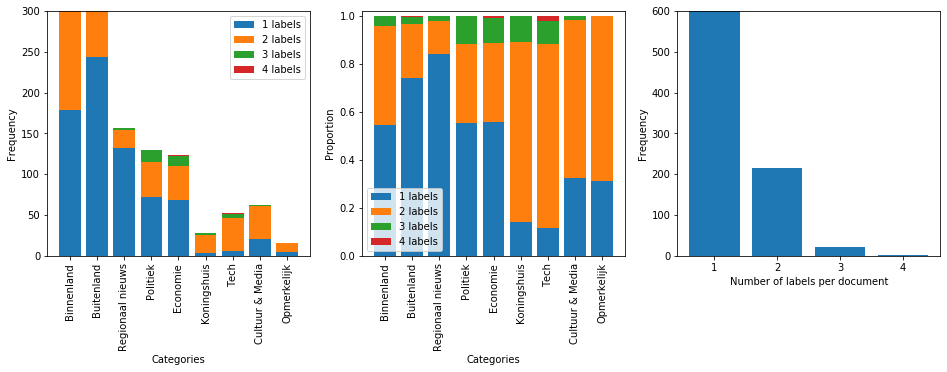

In [13]:
plt.figure(figsize=(16,4.5))
n_labels = np.sum(y, axis=1)

shared_labels = []
for i in range(9):
    counts = list(np.unique(n_labels[y[:,i]==1], return_counts=True)[1])
    counts.extend([0]*(9-len(counts)))
    shared_labels.append(counts)
shared_labels = np.asarray(shared_labels)

for i in range(4):
    plt.subplot(1,3,1).bar(categories, 
                           shared_labels[:,i], 
                           bottom=np.sum(shared_labels[:,:i], axis=1), 
                           label=f"{i+1} labels")
plt.legend(loc="best")
plt.ylim(0,300)
plt.xlabel("Categories")
plt.xticks(rotation=90)
plt.ylabel("Frequency")

for i in range(4):
    plt.subplot(1,3,2).bar(categories, 
                           shared_labels[:,i]/np.sum(shared_labels,axis=1), 
                           bottom=np.sum(shared_labels[:,:i], axis=1)/np.sum(shared_labels,axis=1), 
                           label=f"{i+1} labels")
plt.legend(loc="best")
plt.ylim(0,1.02)
plt.xlabel("Categories")
plt.xticks(rotation=90)
plt.ylabel("Proportion")

labels, count = np.unique(np.sum(y, axis=1), return_counts=True)
plt.subplot(1,3,3).bar(labels.astype(str), count)
plt.xlabel("Number of labels per document")
plt.ylabel("Frequency")
plt.ylim(0,600)
plt.savefig("images/Label_distributions.png", bbox_inches="tight", transparent=True)

## Modelling

The train test split has been already been carried out above. The data is now attributed to common practice variable names and the validation set is further split from training set for initial testing.

In [14]:
X = train_word_importance
y = one_hot_labels[:test_idx]

X_test = test_word_importance
y_test = one_hot_labels[test_idx:]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"     Train size | {X_train.shape}")
print(f"Validation size | {X_val.shape}")
print(f"      Test size | {X_test.shape}")

     Train size | (726, 24435)
Validation size | (242, 24435)
      Test size | (242, 24435)


The algorithm used for classification is the `LogisitcRegression` classifier. As it is a binary classifier it is augmented using the `OneVsRestClassifier` provided by sklearn. This method creates a classifier per class and fits them on one class each. As there are nine labels, which are also imbalanced, this method is prefered to the `OneVsOneClassifier`, which creates a classifier per unique class pair.

In [17]:
model = OneVsRestClassifier(LogisticRegression(penalty="l2", C=10, max_iter=10000))
model = model.fit(X_train, y_train)
val_pred = model.predict(X_val)

print(f"Precision | {precision_score(y_val, val_pred, average='macro'):.2f}")
print(f"   Recall | {recall_score(y_val, val_pred, average='macro'):.2f}")
print(f" F1 score | {f1_score(y_val, val_pred, average='macro'):.2f}")

Precision | 0.82
   Recall | 0.25
 F1 score | 0.36


## Hyperparameter tuning

The initial results can be improved by hyperparameter tuning. The hyperparameter C of the `LogisticRegression` classifier is the inverse regularization strength and is tested in the range from 1 to 100 with a step size of 2.

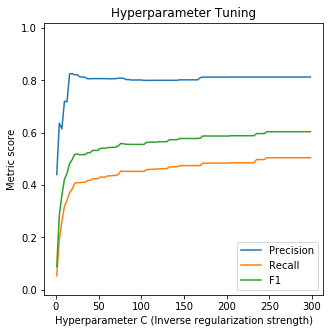

Highest F1 score 0.60 (C = 247)


In [17]:
c_range = np.arange(1,300,3)
precision_scores = []
recall_scores = []
f1_scores = []

for i in c_range:
    model = OneVsRestClassifier(LogisticRegression(penalty="l2", C=i, max_iter=10000))
    model = model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    precision_scores.append(precision_score(y_val, predictions, average="macro"))
    recall_scores.append(recall_score(y_val, predictions, average="macro"))
    f1_scores.append(f1_score(y_val, predictions, average="macro"))

plt.figure(figsize=(5,5))
plt.plot(c_range, precision_scores, label="Precision")
plt.plot(c_range, recall_scores, label="Recall")
plt.plot(c_range, f1_scores, label="F1")
plt.legend(loc="lower right")
plt.xlabel("Hyperparameter C (Inverse regularization strength)")
plt.ylabel("Metric score")
plt.ylim(-0.02, 1.02)
plt.title("Hyperparameter Tuning")
plt.savefig("images/Hyperparameter tuning.png", bbox_inches="tight", transparent=True)

C = c_range[np.argmax(f1_scores)]
print(f"Highest F1 score {np.max(f1_scores):.2f} (C = {C})")

## Evaluation

In order to properly evaluate the tuned model I wanted to perform stratified k-fold cross validation. In a multi-label context this is not easily possible. Due to the class imbalance, number of classes and small sample size, defining the stratifications in terms of each unique class combination was infeasible. Instead, [Jessica Collins](https://stats.stackexchange.com/users/9568/jessica-collins) recommended on [Stack Overflow](https://stats.stackexchange.com/questions/65828/how-to-use-scikit-learns-cross-validation-functions-on-multi-label-classifiers/65840#65840) to attempt to maintain the distribution of the individual class labels over the k-folds regardless of the combinations. As the classifier was trained one vs rest, this method appeared a good fit. 
Jessica Collins provides code in her answer that creates indexes for stratified k-fold cross validation for multilabel data. I am using her code in the cell below with a slight alteration by adding a verbose parameter.

In [15]:
def proba_mass_split(y, folds, verbose=False):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in np.arange(folds):
        index_list.append([])
    for i in np.arange(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
    if verbose:
        print("Fold distributions are")
        print(fold_dist)
    return index_list

The tuned model is cross validated over 5 folds using the stratification method outlined above. The predictions are saved per fold and the metrics are calculated on the training set as a whole. The precision, recall, and f1 score are given per class label (category). Below the first dashed line are the validation results using  the macro averaged (ignoring class imbalance) method. The final row is the performance of the model on the test set when trained on the entire training set.

In [18]:
predictions = []
test_cases = []

split_idx  = proba_mass_split(y, folds=5)

for test_idx in split_idx:
    train_idx = np.array([x for x in np.arange(y.shape[0]) if x not in test_idx])
    
    model = OneVsRestClassifier(LogisticRegression(penalty="l2", C=C, max_iter=10000))
    model = model.fit(X[train_idx], y[train_idx])
    predictions.extend(model.predict(X[test_idx]))
    test_cases.extend(y[test_idx])

predictions = np.asarray(predictions)
test_cases = np.asarray(test_cases)

precision = precision_score(test_cases, predictions, average=None)
recall = recall_score(test_cases, predictions, average=None)
f1 = f1_score(test_cases, predictions, average=None)

for i in range(9):
    print(f"{categories[i]:>16} | {precision[i]:5>.2f} | {recall[i]:5>.2f} | {f1[i]:5>.2f} |")

macro_precision = precision_score(test_cases, predictions, average="macro") 
macro_recall = recall_score(test_cases, predictions, average="macro") 
macro_f1 = f1_score(test_cases, predictions, average="macro") 
print("-"*39)
print(f"  Validation set | {macro_precision:5>.2f} | {macro_recall:5>.2f} | {macro_f1:5>.2f} |")


## Test set performance
model = OneVsRestClassifier(LogisticRegression(penalty="l2", C=C, max_iter=10000))
model = model.fit(X, y)
test_pred = model.predict(X_test)

test_precision = precision_score(y_test, test_pred, average="macro") 
test_recall = recall_score(y_test, test_pred, average="macro") 
test_f1 = f1_score(y_test, test_pred, average="macro")

print("-"*39)
print(f"        Test set | {test_precision:5>.2f} | {test_recall:5>.2f} | {test_f1:5>.2f} |")

      Binnenland | 0.68 | 0.53 | 0.60 |
      Buitenland | 0.92 | 0.78 | 0.84 |
Regionaal nieuws | 0.83 | 0.52 | 0.64 |
        Politiek | 0.91 | 0.65 | 0.76 |
        Economie | 0.80 | 0.44 | 0.57 |
     Koningshuis | 1.00 | 0.68 | 0.81 |
            Tech | 0.95 | 0.38 | 0.55 |
 Cultuur & Media | 0.94 | 0.24 | 0.38 |
     Opmerkelijk | 0.00 | 0.00 | 0.00 |
---------------------------------------
  Validation set | 0.78 | 0.47 | 0.57 |
---------------------------------------
        Test set | 0.77 | 0.49 | 0.58 |


The performance of the model vary depending on the category. Classifying *Buitenland* news was easier than *Binnenland* news even though similar numbers of samples were available. *Buitenland* was classified with the highest f1 score. The second highest f1 score was achieved for the *Konigshuis* category, probably due to the very specific words used in these articles (e.g. konig, máxima, delphine, albert). Articles not labeled *Konigshuis* are very unlikely to feature these words. The idea is that cateogries with more unique words (high TF-IDF scores) should be easier to classify.

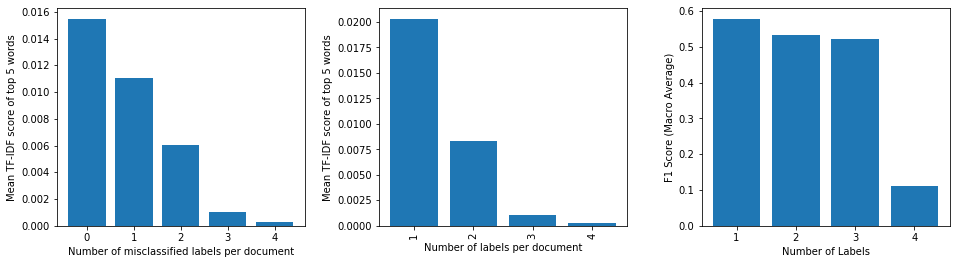

In [20]:
n_mistakes = np.sum(np.abs(predictions-test_cases), axis=1)

values = [np.mean(np.mean(np.sort(train_word_importance[np.where(n_mistakes==i)[0]], axis=0)[-5:,:],axis=0)) for i in range(9)]

plt.figure(figsize=(16,4))
plt.subplot(1,3,1).bar(np.arange(9).astype(str), values)
plt.xlabel("Number of misclassified labels per document")
plt.ylabel("Mean TF-IDF score of top 5 words")

values = [np.mean(np.mean(np.sort(train_word_importance[np.where(n_labels==i)[0]], axis=0)[-5:,:],axis=0)) for i in range(1,10)]
plt.subplot(1,3,2).bar(np.arange(1,10).astype(str), values)
plt.xlabel("Number of labels per document")
plt.xticks(rotation=90)
plt.ylabel("Mean TF-IDF score of top 5 words")

avg_f1s = [f1_score(test_cases[n_labels==i], predictions[n_labels==i], average="macro") for i in range(1,5)]
plt.subplot(1,3,3).bar(np.arange(1,5).astype(str), avg_f1s)
plt.xlabel("Number of Labels")
plt.ylabel("F1 Score (Macro Average)")

plt.subplots_adjust(wspace=0.3)
plt.savefig("images/scores_by_labels.png", bbox_inches="tight")

Documents with low TF-IDF scores should have more misclassifications. The graph on the left shows that as the number of label misclassifications increases the average TF-IDF score of the top 5 words decreases. The graph in the center shows that documents with more labels tend to have lower TF-IDF scores.The graph on the right shows that when considering documents with more than two labels, the F1 score is significantly lower.

## Sample Size

The sample size of a data set has a large impact on the performance of algorithms. Generally, the more data is available the more an algorithm can learn. Larger sample sizes capture more edge cases and provide more evidence and thus more certainty for central relationships. The amount of data needed for good performance differs from case to case. The graph on the left explores how the performance of the model improves as the size of the train data set increases. The graph on the right shows how the vocabulary known to the model increases as it is exposed to more documents.

In [19]:
n = X.shape[0]
x_range = []
vocab = []
f1_values = []

for i in range(0,n,50):
    training_data = X[:i+50,:]
    training_labels = y[:i+50,:]
    vocab_size = np.sum(np.sum(training_data, axis=0)>0)
    
    model = OneVsRestClassifier(LogisticRegression(penalty="l2", C=40, max_iter=10000))
    model = model.fit(training_data, training_labels)
    val_pred = model.predict(X_test)
    
    x_range.append(training_data.shape[0])
    vocab.append(vocab_size)
    f1_values.append(f1_score(y_test, val_pred, average='macro'))

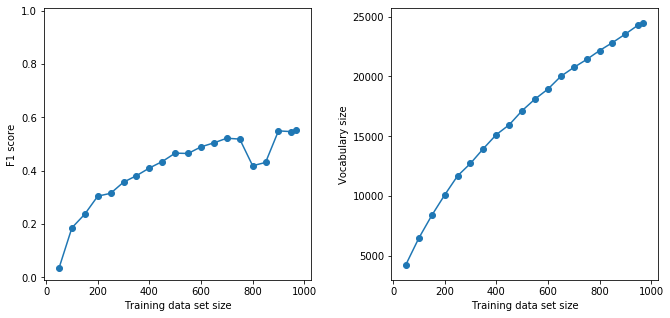

In [21]:
plt.figure(figsize=(11,5))
plt.subplot(1,2,1).plot(x_range, f1_values)
plt.subplot(1,2,1).scatter(x_range, f1_values)
plt.xlabel("Training data set size")
plt.ylabel("F1 score")
plt.ylim(-.01,1.01)

plt.subplot(1,2,2).plot(x_range, vocab)
plt.subplot(1,2,2).scatter(x_range, vocab)
plt.xlabel("Training data set size")
plt.ylabel("Vocabulary size")

plt.subplots_adjust(wspace=0.3)
plt.savefig("images/sample_size.png", bbox_inches="tight")

# Zipfian Distribution

When learning about Natural Language Processing one inevitably comes accross Zipf's Law, which states, acording to wikipedia, that *the frequency of any word is inversely proportional to its rank in the frequency table*. In essence this means that the most common words make up most words of a language. More specifically the first word will be twice as common as the second most common word and three times as common as the third most common word and so on (when s=1). <br>
<br>
<center>$\displaystyle f(k;s,N)=\frac{\frac{1}{k^{s}}}{\sum\limits _{n=1} ^{N}\Big(\frac{1}{n^{s}}\Big)}$</center><br>

In [22]:
def zipfian(k,s=1):
    numerator = 1/(k**s)
    harmonic_number = np.sum(1/(k**s))
    return numerator/harmonic_number

I was of course of interested to see whether my self made corpus followed this distribution. The graph below shows that it follows the theoretical distribution farily closely.

In [23]:
total_word_counts = {}
for dictionary in dictionaries:
    for word in dictionary.keys():
        if word in total_word_counts:
            total_word_counts[word] += dictionary[word]
        else:
            total_word_counts[word] = dictionary[word]

Corpus Vocabulary: 27774
Corpus Size: 438389


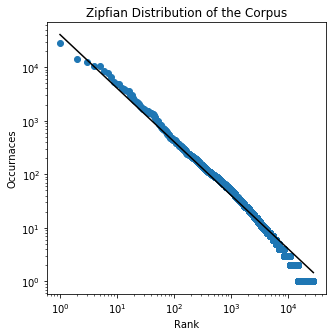

In [24]:
occurances = np.sort(list(total_word_counts.values()))[::-1]
rank = np.arange(1,len(occurances)+1)
words = sum(occurances)

print(f"Corpus Vocabulary: {len(total_word_counts)}")
print(f"Corpus Size: {words}")

plt.figure(figsize=(5,5))
plt.scatter(rank, occurances)
plt.plot(rank, zipfian(rank,s=1)*words, color="black", zorder=1)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Rank"); plt.ylabel("Occurnaces")
plt.title("Zipfian Distribution of the Corpus")
plt.savefig("images/zipfian_distribution.png", bbox_inches="tight", transparent=True)

The created corpus fits the zipfian distribution rather well. Given this fact, can a good estimate of the unique number of words in a given document be found? The graph below shows that this is indeed possible, however, the size of the vocabulary used to instantiate the zipfian distribution needs to be adjusted. The vocabulary size that appears to be a good fit is 3000 words. This indicates that for a given news story there appears to be a estimated domain vocabulary of 3000 words.

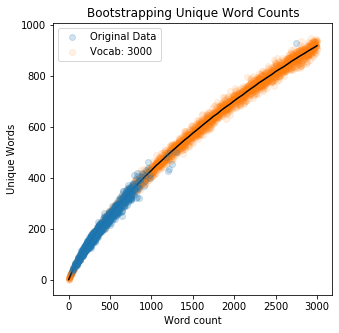

In [28]:
plt.figure(figsize=(5,5))
plt.scatter(article_stats[:,0], article_stats[:,1], alpha=0.2, label="Original Data", zorder=10)

new_rank = np.arange(1,3000)
p = zipfian(new_rank, s=1)
n_unique = []
n_unique_boot = []
n_values = []
n_values_boot = []

for i in range(1,3001):
    values = np.random.choice(new_rank, size=i, p=p)
    n_unique.append(len(np.unique(values)))
    n_values.append(i)

    if (i%50==0) | (i==1):
        values_boot = [len(np.unique(np.random.choice(new_rank, size=i, p=p))) for _ in range(1000)]
        n_unique_boot.append(np.mean(values_boot))
        n_values_boot.append(i)

n_unique = np.asarray(n_unique)
n_unique_boot = np.asarray(n_unique_boot)

    
plt.scatter(n_values, n_unique, alpha=0.1, label=f"Vocab: {3000}")
plt.plot(n_values_boot, n_unique_boot, zorder=1, color="black")
    

plt.legend(loc="best")
plt.xlabel("Word count")
plt.ylabel("Unique Words")
plt.title("Bootstrapping Unique Word Counts")

plt.savefig("images/Bootstrap.png", bbox_inches="tight", transparent=True)
plt.show()